# Jupyter Notebook for Task 3: Cluster Analysis

#### Preparation

In [90]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

charging_data = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))

## 1 Data Preparation for Clustering

As a first step, we need to prepare the data for clustering. This includes adding some additional features or filtering/ separating the data and scaling the selected features.

In [91]:
# Extract the hour from 'connectionTime' and 'disconnectTime' and at those as features to the charging_data dataframe
charging_data['connection_hour'] = charging_data['connectionTime'].dt.hour
charging_data['disconnect_hour'] = charging_data['disconnectTime'].dt.hour

# Add column 'User' to charging_data dataframe to better differ between registered and unregistered users for evaluation purposes
charging_data['User'] = charging_data['userID'].apply(lambda x: 'Unregistered' if x == '' else 'Registered')

In [92]:
# Scaling the selected features with sklearn's StandardScaler
scaler = StandardScaler()
charging_data_cluster = charging_data.copy()
charging_data_cluster_2 = charging_data.copy()
charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']] = scaler.fit_transform(charging_data_cluster[['kWhDelivered', 'connection_duration']])
#charging_data_cluster_2[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour_T', 'disconnect_hour_T']] = scaler.fit_transform(charging_data_cluster_2[['kWhDelivered', 'connection_duration', 'charging_duration', 'connection_hour', 'disconnect_hour']])

We have decided to only select the features `kWhDelivered` and `connection_duration` because adding more features to the following clustering algorithm and plotting the clusters in a two-dimensional plot, makes the clusters harder to see/differentiate visually. </br>
The features `kWhDelivered` and `connection_duration` provide essential and complementary information about user charging behaviour and help differentiate archetypal charging events. We are of the opinion that `connection_duration` is a better choice than `charging_duration` because it gives the full context about the session length (includes idle time) and additionally `charging_duration` is highly correlated with `kWhDelivered`, which would create redundancy in information.</br>
Furthermore temporal features like connection and disconnect hours may not directly influence energy or time consumption, making them less critical for clustering. This can be seen in the following pairplot where several features are displayed against each other.

## 2 Clustering

### Pairplot overview

In [93]:
X_means = KMeans(n_clusters=3, init='k-means++', n_init='auto', random_state=42)
charging_data_cluster['X_means'] = X_means.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']])
#charging_data_cluster_2['X_means'] = X_means.fit_predict(charging_data_cluster_2[['kWhDelivered_T', 'connection_duration_T', 'charging_duration_T', 'connection_hour_T', 'disconnect_hour_T']])

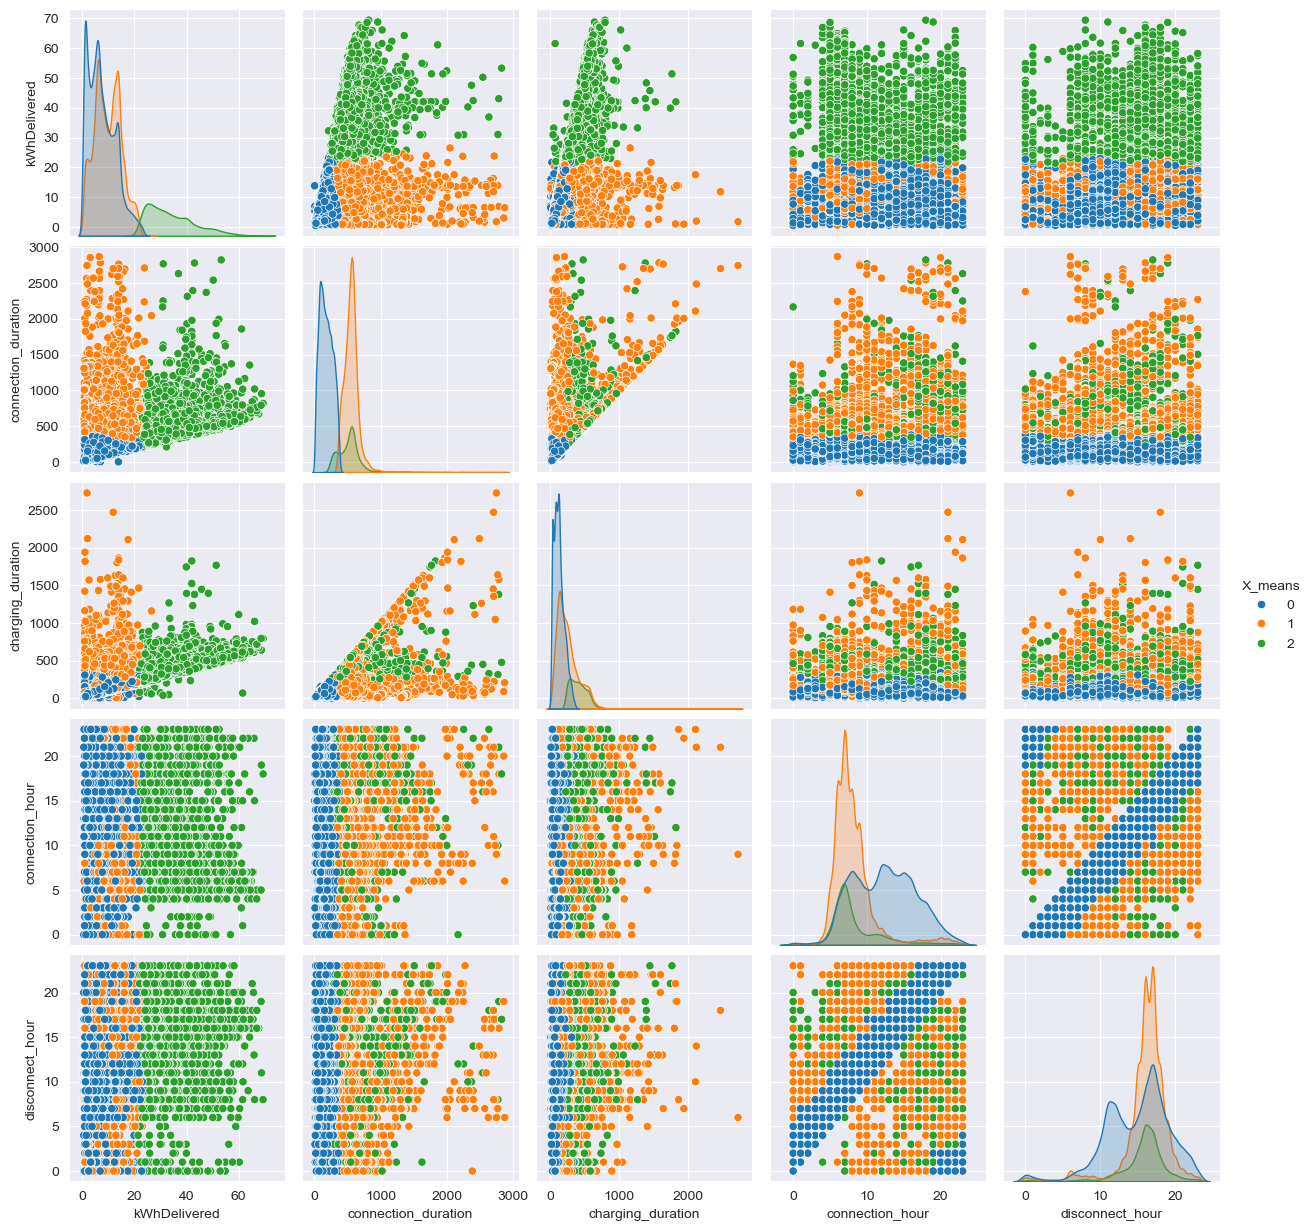

In [94]:
sns.pairplot(data=charging_data_cluster, hue='X_means', vars=['kWhDelivered', 'connection_duration', 'charging_duration', 'connection_hour', 'disconnect_hour'], palette='tab10')
#sns.pairplot(data=charging_data_cluster_2, hue='X_means', vars=['kWhDelivered', 'connection_duration', 'charging_duration', 'connection_hour', 'disconnect_hour'], palette='tab10')

### 2.1 Elbow-Method

**Selected Clustering algorithm: k-means++** </br>
The k-means++ algorithm is an improved version of the classical k-means algorithm. It focuses on solving the initialization problem of k-means by selecting better initial cluster centroids.
Instead of selecting them randomly (as in classical k-means), k-means++ selects centroids in a way that maximizes the distance between them.
This enhancement helps k-means achieve better clustering results and reduces the likelihood of converging to a suboptimal solution.

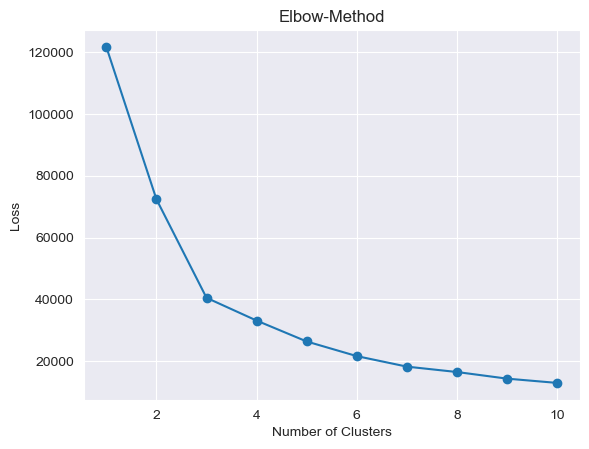

In [95]:
losses = [] # Measure of how well the data was clustered by the k-means algorithm (sum of squared distances to the nearest cluster center)
# As the number of clusters increases the loss will decrease
for k in range(1, 11): # Testing k values from 1 to 10
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    # init='k-means++' selects k-means++ as the clustering algorithm
    # n_init='auto' defines how often the algorithm is repeated with different random initializations of the cluster centroids. This helps to increase the probability of finding an optimal clustering.
    # random_state=42 ensures that the results of the algorithm are reproducible

    kmeans.fit(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']])
    losses.append(kmeans.inertia_)

# Elbow-Plot
plt.plot(range(1, 11), losses, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.title('Elbow-Method')
plt.show()

The Elbow-Method indicates that 3 clusters would be the optimal number of clusters, since adding more clusters no longer significantly improves the clustering performance (Loss reduction becomes minimal).

### 2.2 Clustering Algorithm

In [96]:
# Creating multiple clusters
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42)
    charging_data_cluster[f'kmeans_{k}'] = kmeans.fit_predict(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']])

    # Calculate the Silhouette-Score for each kmeans_k with k=2-5
    score = silhouette_score(charging_data_cluster[['kWhDelivered_T', 'connection_duration_T']], charging_data_cluster[f'kmeans_{k}'])
    print(f"Silhouette Score for k={k}: {score}")

Silhouette Score for k=2: 0.41696248177353223
Silhouette Score for k=3: 0.49580247479762846
Silhouette Score for k=4: 0.43264686336101643
Silhouette Score for k=5: 0.4458303820103721


[medium.com: How to Evaluate the Performance of Clustering Algorithms Using Silhouette Coefficient](https://medium.com/@MrBam44/how-to-evaluate-the-performance-of-clustering-algorithms-3ba29cad8c03) </br>
The Silhouette Score is a metric used to evaluate the quality of clustering results. It measures how well-separated the clusters are and how closely data points are grouped within their clusters. The score provides insight into whether the clusters are meaningful and well-defined.

Interpretation of the Silhouette Score: </br>
$S \approx 1$:
Clusters are well-separated, and points are tightly grouped within their clusters.
Indicates excellent clustering.

$S \approx 0$:
Clusters overlap, or the distances between points in the same cluster are similar to distances to points in other clusters.
Indicates unclear cluster boundaries.

$S < 0$:
Points are often closer to a different cluster than to their own.
Indicates poor clustering or misclassification.

As we achieved a Silhouette Score of $\approx 0.496$ for k=3 we need to interpret this result. In practice a score of about 0.5 to 0.7 is seen as a reasonable clustering, which is well-defined, but not perfect.

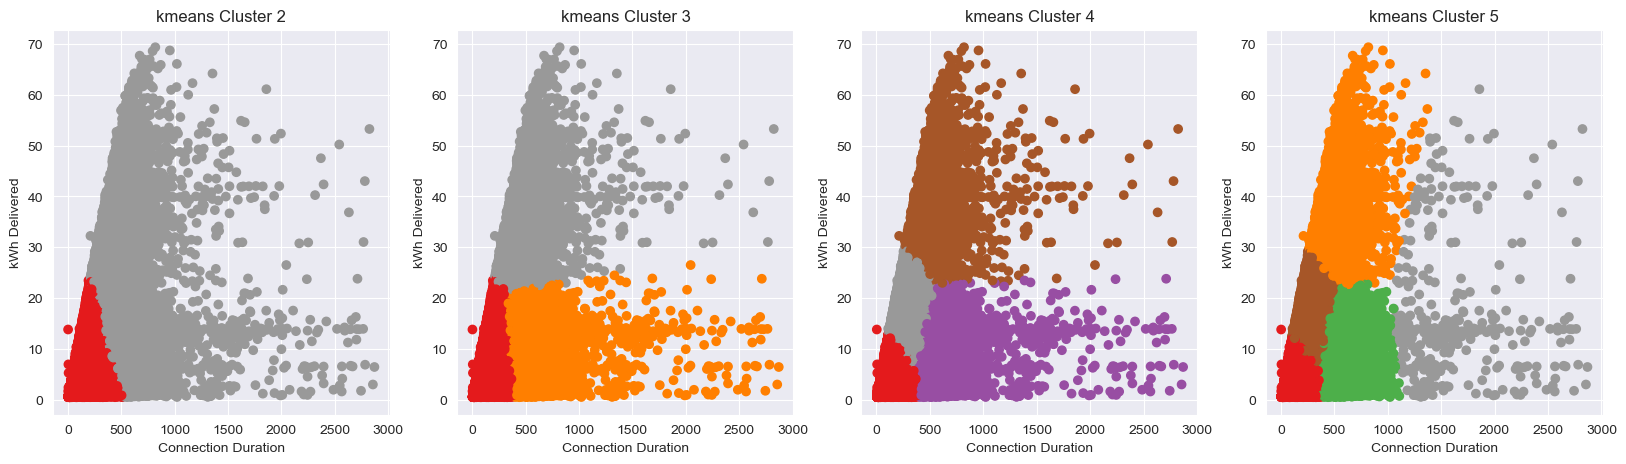

In [97]:
# Creating multiple scatter plots for different kmeans clusters
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
for i, ax in enumerate(fig.axes, start=1):
    ax.scatter(x=charging_data_cluster['connection_duration'], y=charging_data_cluster['kWhDelivered'], c=charging_data_cluster[f'kmeans_{i+1}'], cmap='Set1')
    ax.set_title(f'kmeans Cluster {i+1}')
    ax.set_xlabel('Connection Duration')
    ax.set_ylabel('kWh Delivered')

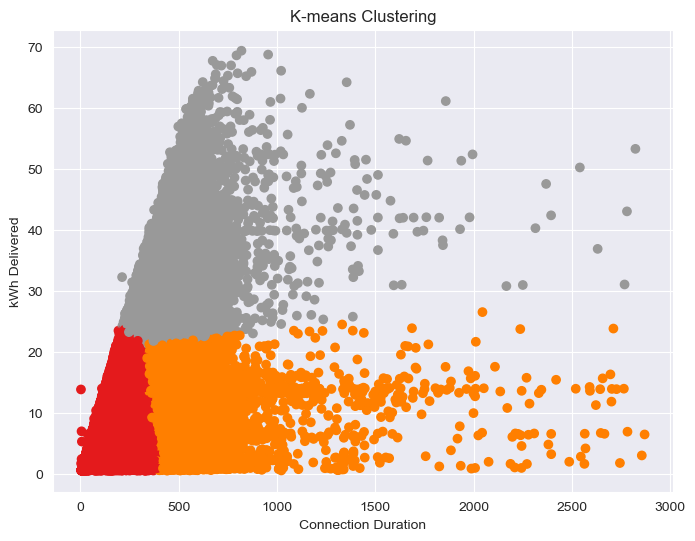

In [105]:
# Scatter plot for k-means with 3 clusters
plt.figure(figsize=(8, 6))
plt.scatter(
    x=charging_data_cluster['connection_duration'],
    y=charging_data_cluster['kWhDelivered'],
    c=charging_data_cluster['kmeans_3'],
    cmap='Set1'
)
plt.title('K-means Clustering')
plt.xlabel('Connection Duration')
plt.ylabel('kWh Delivered')
plt.show()

In [98]:
# Display cluster summaries for kmeans Cluster 2-5
cluster_summaries = {}
for k in range(2, 6):
    cluster_column = f'kmeans_{k}'  # Column name for the current KMeans clustering
    if cluster_column in charging_data_cluster.columns:
        # Group by cluster and calculate mean for relevant features
        summary = charging_data_cluster.groupby(cluster_column)[['kWhDelivered', 'charging_duration', 'connection_duration', 'connection_hour', 'disconnect_hour']].mean()
        # Add cluster sizes
        summary['cluster_size'] = charging_data_cluster[cluster_column].value_counts()
        site_counts = charging_data_cluster.groupby([cluster_column, 'siteID']).size().unstack(fill_value=0)
        summary['site1_size'] = site_counts.get("1", 0)
        summary['site2_size'] = site_counts.get("2", 0)
        cluster_summaries[k] = summary

# Display summaries for each KMeans configuration
for k, summary in cluster_summaries.items():
    print(f"\nSummary for KMeans (k={k}):")
    display(cluster_summaries[k])


Summary for KMeans (k=2):


,kWhDelivered,charging_duration,connection_duration,connection_hour,disconnect_hour,cluster_size,site1_size,site2_size
kmeans_2,,,,,,,,
0,6.971752,123.221992,190.159781,12.196245,15.008262,29774,12201,17573
1,16.005134,292.636614,554.752063,8.214380,15.989407,31057,19377,11680



Summary for KMeans (k=3):


,kWhDelivered,charging_duration,connection_duration,connection_hour,disconnect_hour,cluster_size,site1_size,site2_size
kmeans_3,,,,,,,,
0,7.438367,122.905193,173.833816,12.375213,14.923309,28152,11952,16200
1,9.710102,249.575485,560.311595,8.174835,16.087102,25361,13863,11498
2,34.023715,405.536494,517.480215,8.545504,15.760180,7318,5763,1555



Summary for KMeans (k=4):


,kWhDelivered,charging_duration,connection_duration,connection_hour,disconnect_hour,cluster_size,site1_size,site2_size
kmeans_4,,,,,,,,
0,4.970285,95.703158,147.656755,12.726234,14.795750,20470,7490,12980
1,9.184396,247.793227,574.877383,8.105320,16.156577,23158,12709,10449
2,36.435418,435.355278,562.606391,8.175841,15.863676,5795,4612,1183
3,15.696979,222.379373,288.823976,10.751841,15.295056,11408,6767,4641



Summary for KMeans (k=5):


,kWhDelivered,charging_duration,connection_duration,connection_hour,disconnect_hour,cluster_size,site1_size,site2_size
kmeans_5,,,,,,,,
0,4.789516,93.345916,143.907935,12.765068,14.768072,19644,7066,12578
1,9.238869,244.476404,558.193176,8.058461,16.180105,23503,12969,10534
2,35.928068,428.944274,543.381832,8.122033,15.859244,5982,4795,1187
3,15.214088,214.066649,273.994921,10.965319,15.282298,11332,6709,4623
4,16.470924,502.332207,1592.405135,14.175676,13.527027,370,39,331


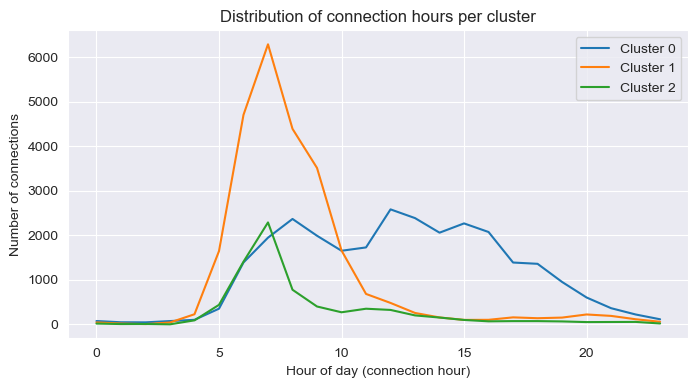

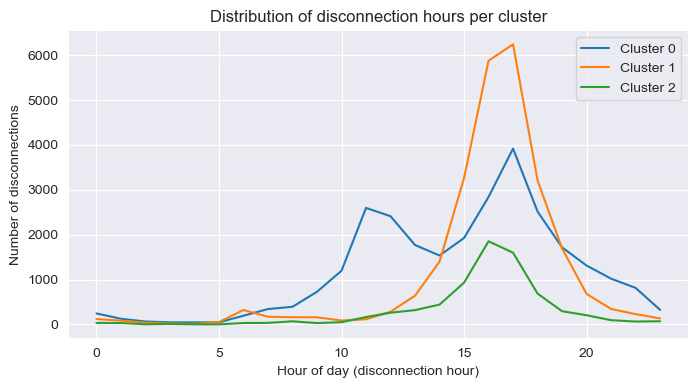

In [99]:
# Group data by cluster and hours
connection_hourly = charging_data_cluster.groupby(['kmeans_3', 'connection_hour']).size().unstack(fill_value=0)
disconnect_hourly = charging_data_cluster.groupby(['kmeans_3', 'disconnect_hour']).size().unstack(fill_value=0)

# Plot line chart for connection hours
plt.figure(figsize=(8, 4))
for cluster in connection_hourly.index:
    plt.plot(connection_hourly.columns, connection_hourly.loc[cluster], label=f'Cluster {cluster}')

plt.title('Distribution of connection hours per cluster')
plt.xlabel('Hour of day (connection hour)')
plt.ylabel('Number of connections')
plt.legend()
plt.grid(True)
plt.show()

# Plot line chart for disconnection hours
plt.figure(figsize=(8, 4))
for cluster in disconnect_hourly.index:
    plt.plot(disconnect_hourly.columns, disconnect_hourly.loc[cluster], label=f'Cluster {cluster}')

plt.title('Distribution of disconnection hours per cluster')
plt.xlabel('Hour of day (disconnection hour)')
plt.ylabel('Number of disconnections')
plt.legend()
plt.grid(True)
plt.show()

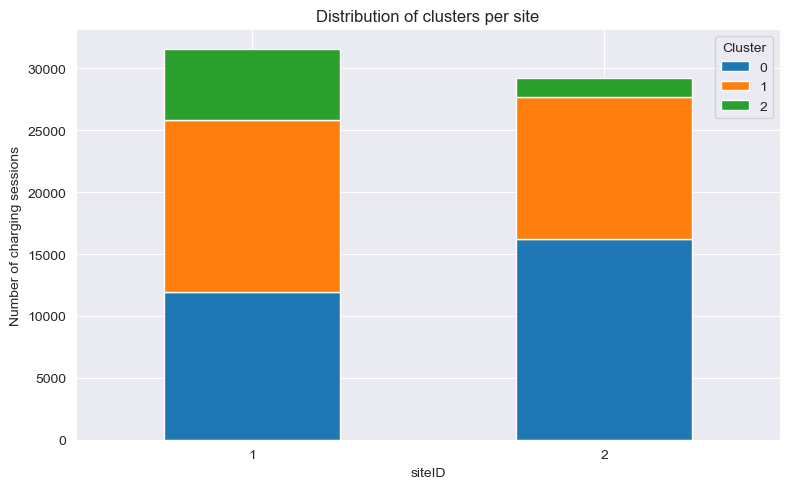

In [102]:
# Group data by cluster and site
site_cluster_counts = charging_data_cluster.groupby(['siteID', 'kmeans_3']).size().unstack(fill_value=0)

# Bar chart of the distribution of cluster per site
site_cluster_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Distribution of clusters per site')
plt.xlabel('siteID')
plt.ylabel('Number of charging sessions')
plt.legend(title='Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Given the summary of the mean values of kWhDelivered, charging_duration, connection_duration, connection_hour and disconnect_hour for k=3 and the plots above, we can identify 3 typical charging sessions and their characteristics. Additionally, we have calculated the size of each cluster and how many belong to site 1 and site 2.

**Cluster 0 (red): Short chargers / Top-up charging** </br>
The first cluster (red) is characterized by low energy delivered (up to ~25 kWh) and short connection durations (up to ~400 minutes). This behavior typically reflects “top-up charging” patterns, where users partially charge their vehicles to add a few extra miles. It may also include users of smaller battery EVs, which require less energy to reach full capacity. </br>
Analysis of the connection_hour and disconnect_hour reveals that the mean charging sessions occur around midday to the afternoon and are relatively even distributed throughout the day, suggesting a non-work-related charging pattern. This could involve users visiting public locations like shopping centers, cafes, or restaurants and the mentioned university. Supporting this thesis is the observation that 57.5% of the data from this cluster belongs to the public site, further indicating usage in non-workplace / university setting or usage by employees who are not in the office for the whole day. </br>
This user group implies a high turnover rate at charging stations due to their short connection times, which allows for frequent station availability.

**Cluster 1 (yellow): High-demand users** </br>
The second cluster (yellow) is characterized by high energy delivered (up to the maximum of ~70 kWh) and moderate to long connection durations (mostly below ~1000 minutes or 16,6 hours). These users exhibit efficient charging behavior, consuming significant amounts of energy during sessions that align with their charging needs. They are most likely long-distance drivers or users who fully charge their EVs over the course of a workday. </br>
A notable observation is that 78.7% of this cluster’s data originates from the private site, strongly suggesting that most of these users charge their vehicles during working hours. This behavior aligns with the cluster’s mean connection and disconnect times, which follow a typical workday pattern — starting around 8:00 AM and ending around 4:00 PM. </br>
The remaining 21.3% from site 2 could be students or employees of the university who are there the whole day or people who are on a day trip.
This group reflects a consistent and predictable usage pattern, primarily associated with workplace charging or preparing for long-range trips (public users).

**Cluster 2 (grey): Idle Users** </br>
The third and final cluster (grey) is characterized by moderate energy consumption (close to ~30 kWh) paired with long connection durations, resulting in high idle times. This makes these users the most inefficient chargers, as they remain connected for extended periods while consuming only a small to moderate amount of energy. </br>
These users are likely a mix of workplace chargers (private site, site 1) who leave their cars connected for the entire workday, even though they require little energy — potentially due to a short commute to work — and chargers (public site, site 2) who charge overnight or for extended periods. The disproportionate connection durations suggest either a lack of awareness about disconnecting after charging or convenience-driven behavior where users prioritize leaving the car plugged in over station efficiency. </br>
This user group poses a significant challenge to charging station utilization, as they block stations for others who could make better use of the infrastructure.

**Value of identifying different types of charging sessions**
- Detailed insights about your customer base and different customer behaviours
- Operational and strategic planning
- Customer experience improvements
- Identify infrastructure needs (e. g. fast chargers for high-demand users)
- Identify problems in charging behavior (e. g. idle users)
- Opportunity to take measures against undesired behaviour (e. g. policies against idle users)
- Monitoring and continuous improvement: Track and monitor behavioral shifts, evaluate policy effectiveness

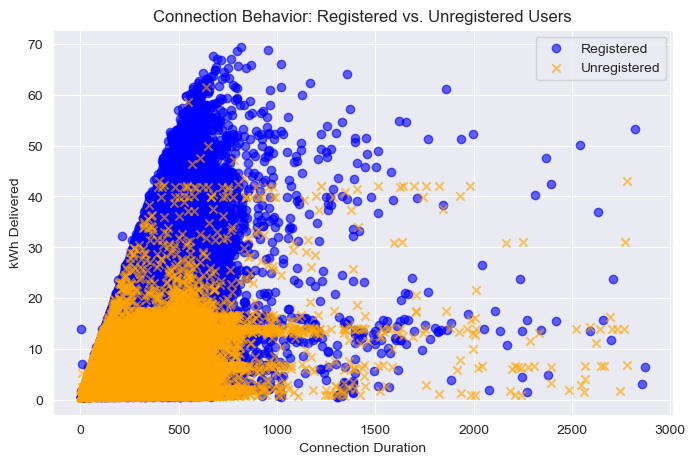

In [101]:
# Separate the data into registered and unregistered users
registered_users = charging_data_cluster[charging_data_cluster['User'] == 'Registered']
unregistered_users = charging_data_cluster[charging_data_cluster['User'] == 'Unregistered']

# Create the scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x=registered_users['connection_duration'], y=registered_users['kWhDelivered'], c='blue', label='Registered', alpha=0.6, marker='o')
plt.scatter(x=unregistered_users['connection_duration'], y=unregistered_users['kWhDelivered'], c='orange', label='Unregistered', alpha=0.6, marker='x')

plt.title('Connection Behavior: Registered vs. Unregistered Users')
plt.xlabel('Connection Duration')
plt.ylabel('kWh Delivered')
plt.legend()
plt.grid(True)
plt.show()

**Registered users:** </br>
Registered users (blue points) exhibit a wide range of behaviors, but most are characterized by efficient charging habits. The majority of registered users charge within moderate connection durations (up to ~1000 minutes) and consume significant energy (up to 70 kWh), which aligns with the needs of frequent or routine users, such as commuters or long-distance drivers.
However, there is a noticeable subset of users with long connection durations (beyond 1000 minutes) but low kWh delivered, likely reflecting idle time after charging is complete, particularly in workplace environments. </br>
This group represents high-value and loyal customers who rely on the charging network for their daily or routine needs.

**Unregistered users:** </br>
Unregistered users (orange crosses) show markedly different behavior. Many fall into the low energy delivered category (0–30 kWh) across a range of connection durations. A significant subset exhibits long connection durations (exceeding 1000 minutes) with minimal energy consumption, suggesting inefficient charging or extended parking at the stations. This pattern is more prevalent in public locations, where unregistered users may use charging stations opportunistically during shopping, dining, or other short-term activities. </br>
This group likely consists of one-time or occasional users, with limited loyalty or awareness of optimal charging practices.